<a href="https://colab.research.google.com/github/robinjameslee/Binance-Mean-Reversion-Strategy/blob/main/binance_mean_reversion_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install ccxt
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import calendar
import matplotlib.pyplot as plt

exchange = ccxt.binanceus()

In [ ]:
def get_all_tickers():
  res = exchange.fetchTickers()
  res = {k: v for k, v in res.items() if '/USDT' in k}
  return res.keys()

def get_all_ohlcv(ticker_list, timeframe, start_time):
  agg_df = pd.DataFrame()

  for ticker in ticker_list:
    try:
      res = exchange.fetch_ohlcv(symbol=ticker, timeframe=timeframe, since=start_time, limit=1000)
      df = pd.DataFrame(res, columns=['Time', 'Open', 'High', 'Low', ticker, 'Volume'])
      if agg_df.empty:
        agg_df = df[['Time', ticker]]
      else:
        agg_df = agg_df.merge(df[['Time', ticker]], how='outer', on='Time')
    except:
      pass

  agg_df['Time'] = pd.to_datetime(agg_df['Time'], unit='ms')
  agg_df = agg_df.sort_values('Time')
  agg_df = get_filtered_df(agg_df)
  return agg_df

def get_filtered_df(df):
  df = df.set_index('Time')
  df = df[-300:] #only take the last 300 trading days
  df = df.dropna(axis='columns') #drop columns with NA
  return df

In [ ]:
timeframe = '1d'
start_time = exchange.parse8601('2022-01-01')

ticker_list = get_all_tickers()
agg_df = get_all_ohlcv(ticker_list, timeframe, start_time)

In [ ]:
num_of_stocks = 10

#Calculate the winners and losers in each week
daily_return = np.log(backtest_df/backtest_df.shift(1))
weekly_return = daily_return.resample('W').agg(lambda x: x.sum())
weekly_winners_index = weekly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)
weekly_losers_index = weekly_return.apply(lambda s, n: s.nsmallest(n).index, axis= 1, n = num_of_stocks)

#Calculate the winners and losers in each month
monthly_return = daily_return.resample('M').agg(lambda x: x.sum())
monthly_winners_index = monthly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)
monthly_losers_index = monthly_return.apply(lambda s, n: s.nsmallest(n).index, axis= 1, n = num_of_stocks)

In [ ]:
# Buy the losers, short the winners every Sunday
weekly_strategy = pd.DataFrame([], columns= ['mean_return'], index=daily_return.index.copy())

for i in range(len(weekly_winners_index) - 1):
    weekend = weekly_return.index[i+1]
    weekly_winners = weekly_winners_index.iloc[i]
    weekly_losers = weekly_losers_index.iloc[i]
    weekly_winners_return = daily_return.loc[weekend-timedelta(days = 6):weekend, weekly_return.columns.isin(weekly_winners)]
    weekly_losers_return = daily_return.loc[weekend-timedelta(days = 6):weekend, weekly_return.columns.isin(weekly_losers)]
    weekly_strategy.loc[weekend-timedelta(days = 6):weekend, 'mean_return'] = -weekly_winners_return.mean(axis = 1) + weekly_losers_return.mean(axis = 1) #Short winners, long losers

weekly_strategy = weekly_strategy.dropna()

In [ ]:
# Buy the losers, short the winners for the month
monthly_strategy = pd.DataFrame([], columns= ['mean_return'], index=daily_return.index.copy())

for i in range(len(monthly_winners_index) - 1):
    monthend = pd.to_datetime(monthly_return.index[i+1], format = '%Y-%m-%d')
    daysInMonth= int(calendar.monthrange(monthend.year, monthend.month)[1])

    monthly_winners = monthly_winners_index.iloc[i]
    monthly_losers = monthly_losers_index.iloc[i]

    monthly_winners_return = daily_return.loc[monthend-timedelta(days = daysInMonth-1):monthend, monthly_return.columns.isin(monthly_winners)]
    monthly_losers_return = daily_return.loc[monthend-timedelta(days = daysInMonth-1):monthend, monthly_return.columns.isin(monthly_losers)]
    monthly_strategy.loc[monthend-timedelta(days = daysInMonth-1):monthend, 'mean_return'] = -monthly_winners_return.mean(axis = 1) + monthly_losers_return.mean(axis = 1) #Short winners, long losers

monthly_strategy = monthly_strategy.dropna()

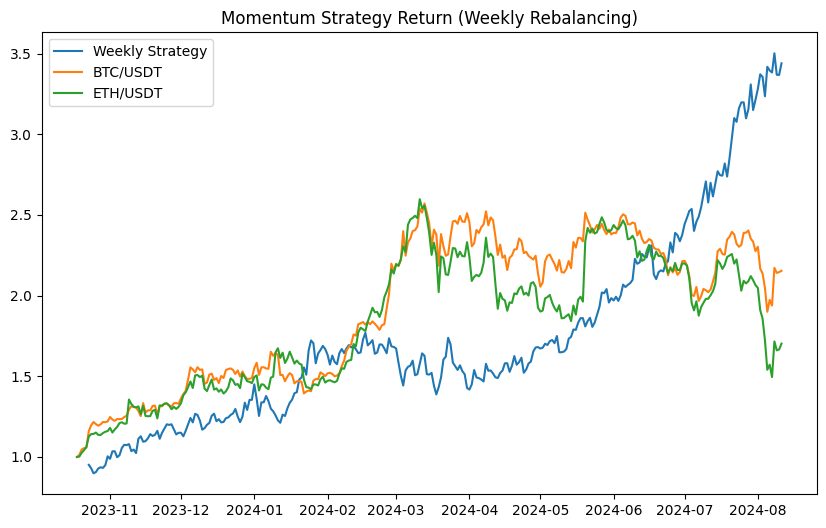

In [ ]:
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Weekly Rebalancing)')
ax.plot(weekly_strategy['mean_return'].astype(float).cumsum().apply(np.exp), label = 'Weekly Strategy')
ax.plot(daily_return['BTC/USDT'].cumsum().apply(np.exp), label = 'BTC/USDT')
ax.plot(daily_return['ETH/USDT'].cumsum().apply(np.exp), label = 'ETH/USDT')
ax.legend()

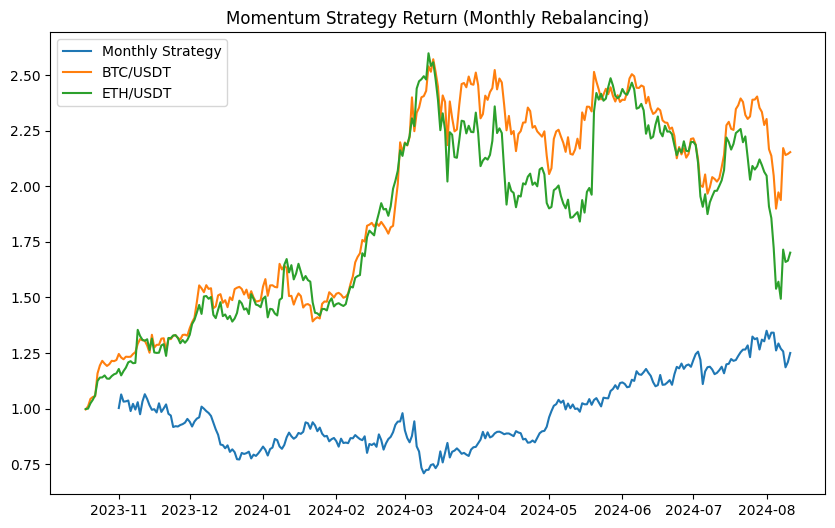

In [ ]:
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Monthly Rebalancing)')
ax.plot(monthly_strategy['mean_return'].astype(float).cumsum().apply(np.exp), label = 'Monthly Strategy')
ax.plot(daily_return['BTC/USDT'].cumsum().apply(np.exp), label = 'BTC/USDT')
ax.plot(daily_return['ETH/USDT'].cumsum().apply(np.exp), label = 'ETH/USDT')
ax.legend()